In [128]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal

class GMM:
    def __init__(self, k, method='random_mean_std', max_iter=300, tol=1e-6):
        self.k = k 
        self.method = method
        self.max_iter = max_iter
        self.tol = tol
    
    def init_centers(self, X):
        if self.method == 'random_mean_std':
            pass # generating K random means and std-s
        if self.method == 'random_mean':
            pass # generate K random means
        if self.method == 'k-means':
            kmeans = KMeans(n_clusters = self.k)
            kmeans.fit(X)
            clusters = kmeans.predict(X)
            mean_arr = kmeans.cluster_centers_
            cov_arr = []
            pi_arr = []
            for i in range(self.k):
                X_i = X[clusters==i]
                cov_arr.append(np.cov(X_i.T))
                pi_arr.append(X_i.shape[0]/X.shape[0])
            return mean_arr, np.array(cov_arr), np.array(pi_arr)
        
        if self.method == 'random_divide':
            pass # divide data into K clusters randomly
        if self.method == 'random_gammas':
            pass # generate random gamma matrix
        
    
    def fit(self, X):
        self.mean_arr, self.cov_arr, self.pi_arr = self.init_centers(X)
        loss = self.loss(X, self.mean_arr, self.cov_arr, self.pi_arr)
        prev_loss = loss
        for _ in range(self.max_iter):
            gamma_mt = self.expectation(X)
            mean_arr, cov_arr, pi_arr = self.maximization(X, gamma_mt)
            loss = self.loss(X, mean_arr, cov_arr, pi_arr)
            if np.abs(loss-prev_loss) < self.tol:
                break
            prev_loss=loss
            self.mean_arr = mean_arr
            self.cov_arr = cov_arr
            self.pi_arr = pi_arr
            
    def loss(self, X, m, c, pi):
        ln = []
        for i, x in enumerate(X):
            s = 0
            for j in range(self.k):
                s+=pi[j]*self.pdf(x, mean=m[j], cov=c[j])
            ln.append(np.log(s))
            
        return -sum(ln)
    
    def pdf(self, x, mean, cov):
        proba = multivariate_normal.pdf(x, mean, cov)
        
        return proba
            
    def expectation(self, X):
        gamma_mtrx = np.zeros((X.shape[0], self.k))
        for i, x in enumerate(X):
            denominator = 0
            numerator = []
            for j in range(self.k):
                gamma_mtrx[i][j] = self.pi_arr[j]*self.pdf(x, mean=self.mean_arr[j], cov=self.cov_arr[j])
                numerator.append(gamma_mtrx[i][j])
                denominator+=gamma_mtrx[i][j]
            gamma_mtrx[i] = np.array(numerator)/denominator

            
        return gamma_mtrx

    def maximization(self, X, gamma):
        mean_arr = []
        cov_arr = []
        N_k = np.array([gamma[:,k].sum() for k in range(self.k)])
        for k in range(self.k):
            sum_mean = 0
            for i, x in enumerate(X):
                sum_mean+=x*gamma[i][k]
            mean_arr.append(sum_mean/N_k[k])
        mean_arr = np.array(mean_arr)
        for k in range(self.k):
            sum_sigma = 0
            for i, x in enumerate(X):
                sum_sigma+= gamma[i][k]*((x - mean_arr[k]).reshape(X.shape[1],1)).dot((x - mean_arr[k]).reshape(1,X.shape[1]))
            cov_arr.append(sum_sigma/N_k[k])
        cov_arr = np.array(cov_arr)
        pi_arr = N_k/X.shape[0]
        
        return mean_arr, cov_arr, pi_arr   
        
    def predict(self, X):
        labels = np.argmax(self.expectation(X), axis = 1)
        
        return labels
    
    def predict_proba(self, X):
        probs = np.max(self.expectation(X), axis = 1)
        return probs

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

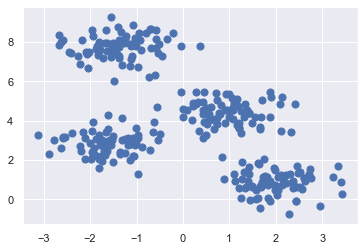

In [130]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

In [131]:
clus = GMM(4, method='k-means', max_iter=300, tol=1e-6)

In [132]:
clus.fit(X)

C:\Users\danie\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [133]:
pr = clus.predict(X)

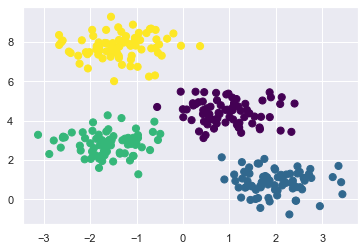

In [134]:
plt.scatter(X[:, 0], X[:, 1], c=pr, s=50, cmap='viridis')


In [136]:
clus.predict_proba(X).shape

(300,)